# MSDS 7331 - Mini-Project 1
## Jeff Weltman, Kevin Dickens, Jordan Kassof
## June 10, 2018

<hr>

# Introduction

**Primer:** We are using the Belk North Carolina Education Dataset [available on Github here](https://github.com/jakemdrew/EducationDataNC) to explore the factors involved when a highschool is succesful. How to decide if a high school is succesful is a complex and controversial issue. While there are many important nuanced considations, we will be using a school's average SAT score as a proxy for it's success. Standardized test scores have been found to be a strong predictor of prosperity, so this seems like a logical approach. [According to The College Board](https://prepexpert.com/average-sat-score/) the state of North Carolina's average individual SAT score is 1080. We will use this as our threshold to identify a school as "outperforming." Finally, we will seek to understand what differentiates the outperforming schools from their peers.

In Lab 1, we explored the relationships in our data using a wide range of summary statistics and data visualizations, please [see this link](https://nbviewer.jupyter.org/github/jeffweltman/MSDS7331/blob/master/NC%20Education%20Data.ipynb) to review those materials.

This data set of North Carolina High Schools was generated by preprocessing steps undertaken both by the author as well as our team in Lab1 1. It therefore already contains our response variable, *sat_high_level*.  
If a High School's average SAT score met or exceeded 1080, the 66th percentile national average score, we classified that as *'high'* (Y=1). 

# Section 1: Create Models

**50	Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe**

In this section, we'll use two classical data mining techniques to further our understanding of the relationships found in our data.

## Section 1A: Logistic Regression

We utilized scikit-learn's ShuffleSplit to produce training and testing subsets of our data, with 80% training data and 20% testing data. Next, we employed 10-fold cross-validation to ensure our model was generalized, rather than overfit. Lastly, we created a pipeline to scale the data and then perform the logistic regression for each step of a grid search in order to obtain the best set of model parameters. We measured the classifier's accuracy and scoring metrics using a function defined by Dr. Jake Drew, which will be publicly available on his [GitHub repo](https://github.com/jakemdrew/EducationDataNC) at a later date.

First, we import the pre-processed data file from our local GitHub repository.

In [2]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
hs_2017 = pd.read_csv("https://github.com/jeffweltman/MSDS7331/raw/master/hs_2017.csv",index_col=0)

Prior to splitting our data for prediction, we can utilize a count plot to show the distribution for our response variable, *sat_high_level*, as a comparison baseline.    
We can see that approximately one-third of the schools meet our predefined threshold, equating to 37.77% of objects having a value of 1 and the remaining 62.23% having a value of 0.

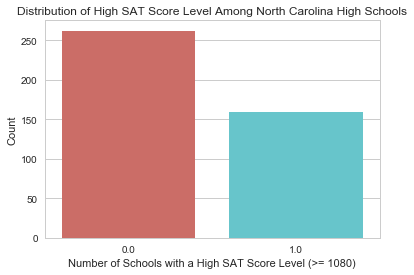

0.0    262
1.0    159
Name: sat_high_level, dtype: int64

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='sat_high_level',data=hs_2017, palette='hls')
plt.xlabel('Number of Schools with a High SAT Score Level (>= 1080)')
plt.ylabel('Count')
plt.title('Distribution of High SAT Score Level Among North Carolina High Schools')
plt.show()
hs_2017['sat_high_level'].value_counts()

First, we establish the parameters for our logistic regression, setting X and Y as well as defining the train/test split.
As we are looking to classify whether or not a school meets or exceeds the threshold for a high SAT score, we will remove the SAT score columns to prevent collinearity.

In [4]:
Y=hs_2017['sat_high_level'].values
hs_2017=hs_2017.drop({'sat_high_level','sat_avg_score_num','lea_sat_avg_score_num'}, axis=1) 
X_highSchools=hs_2017

In [5]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

Next, we define our accuracy and scoring metrics, using the aforementioned functions created by Dr. Drew.

In [6]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)


Now we create a pipeline to employ logistic regression through the steps of a grid search. 

Our final logistic regression model therefore meets these two criteria: 
1. The most optimally-calibrated regression is executed, due to the grid search;
2. The weights are easily interpretable, due to the standard scaling.

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_highSchools, Y)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.01, class_weight='none', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

With our best model in hand, we can assess the performance first of each cross-validation fold.

In [8]:
EvaluateClassifierEstimator(grid.best_estimator_, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.87176
The average precision for all cv folds is: 			 0.84947
The average recall for all cv folds is: 			 0.8107
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.858824,0.866667,0.764706
1,0.858824,0.900000,0.750000
2,0.835294,0.815789,0.815789
3,0.823529,0.750000,0.818182
4,0.858824,0.807692,0.750000
5,0.882353,0.892857,0.781250
6,0.905882,0.903226,0.848485
7,0.917647,0.882353,0.909091
8,0.835294,0.812500,0.764706
9,0.941176,0.863636,0.904762


Lastly, we obtain the confusion matrix and the overall model metrics for precision, recall, f1-score, and support.

In [9]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_highSchools, Y, 10)

             precision    recall  f1-score   support

        0.0       0.88      0.92      0.90       262
        1.0       0.85      0.79      0.82       159

avg / total       0.87      0.87      0.87       421

[[240  22]
 [ 34 125]]
0.8669833729216152


## Section 1B: Support Vector Machines

Support Vector Machines analyze data for logical breaks and are useful for predicting classification of a record.  In this section we will look at scikit-learn's SVM functions to generate a classification model using SVMs.

In [18]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

X_highSchools=hs_2017.values # re-instantiating X to get values f

for train_indices, test_indices in cv.split(X_highSchools,Y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X_highSchools[train_indices]
    y_train = Y[train_indices]
    
    X_test = X_highSchools[test_indices]
    y_test = Y[test_indices]
    
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [17]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# train the SVM model
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set preditions

#Get the model accuracy and the confusion matrix
acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('The accuracy of the SVM is:', acc )
print(conf)

The accuracy of the SVM is: 0.8941176470588236
[[58  6]
 [ 3 18]]


The resulting SVM model shows an accuracy rate of 89% which is slightly better than the logistic regression performed previously.  The confusion rate shows us the actual vs. predicted values.

| n = 88 | Predicted: 0 | Predicted: 1 |
| ------ | ------------ | ------------ |
| Actual: 0 | 58 | 6 |
| Actual: 1 | 3 | 18 |

The confusion matrix shows us the number of true positives, or the correct prediction of high SAT scores as 18.  The number of false positives, or incorrectly predicted high SAT scores as 3.  This are also referred to as type I errors.  The true negatives, or correct predicted of schools without high SAT scores is 58.  While the false negatives, or incorrectly classified schools that don't have high SAT come in at 6.  False negatives are also known as type II errors.  This results in the SVM being a pretty good predictor of both schools with high SAT scores and without high SAT scores.

# Section 2: Model Comparison

**Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.**

In this section we will explore the nature of logistic regression and SVMs, including pros, cons, and other conisderations. As a brief historical primer, Logistic Regression is a technique developed by David Cox in 1958. It uses the logit function to map a set of input attributes ("risk factors") to a probability of the occurance of a binary outcome. Although **technically** logistic regression is not a classifier algorithm (it does not predict classes), by using a threshold, one can convert the probabilistic output into a classification. Practically speaking, logistic regression is likely the most commonly used classification technique across all industries. 

The reasoning for it's popularity (in spite of it's relative age, 60 years old) will become evident as we continue to explore these two methods. Support Vector Machines (SVMs) are another one of the most popular classification techniques out there. The original algorithmic underpinning of SVM (support vector clustering) goes back to the early 1960's, but this implementation gave us a strictly linear classifier. In the early 1990's a method was developed that allowed for non-linear classifiers. This method involves using different types of "kernels." SVM with a linear kernel is for all intents and purposes, *quite* similar to standard logistic regression. As opposed to logistic regression, SVM is a true deterministic classifier algorithm, that is, it outputs class labels, rather than probabilities.

### Section 2A: Prediction Accuracy

The primary factors that dictate whether Logistic Regression or SVM will be a more predictive model for your data are primarily related to the nature of the features of the dataset. SVMs (with an appropriate Kernel choice) can handle linearly inseperable features, as well as high-dimensional feature spaces. It is rather convenient that the two biggest weaknesses of logistic regression are the two biggest strengths of SVM. The below graphic provides a 2-dimensional explanation of what "linearly seperable" means. It is a term for when a straight line can be drawn to separate different classes. 

<center><img src='images/linsep.png'></center>



### Section 2B: Training & Prediction



### Section 2C: Summary Pros & Cons
    
|<p align="left">Method | <p align="left"> Pros | <p align="left"> Cons
|---|---|---
|<p align="left">Logistic Regression |<ul><li><p align="left">Well understood, many efficient implementations across different software packages</li><li><p align="left">Small computational burden for a large number of cases, can be parallelized making it BIG DATA friendly</li><li><p align="left">Well behaved, i.e. robust to small amounts of noise in data, and small amounts of colinearity</li><li><p align="left">Multi-colinearity can be managed with regularization and feature engineering</li><li><p align="left">Probabilistic output provides high utility, one can rank instead of just classify. Also there are more performance measure available as opposed to pure classifier</li></ul> |<ul><li><p align="left">Mainly a linear classifiers (there are tricks to make LR a non-linear clasifier)</li><li><p align="left">Does not perform well with a large number of attributes, especially if they are mostly categorical</li><li><p align="left">Process for handling non-linear variables decreases model parsimony, making interpretation less intuitive</li></ul> 
|<p align="left">SVM |<ul><li><p align="left">Works well in problems with very large feature spaces such as text analysis</li><li><p align="left">Can more easily model non-linear attributes</li><li><p align="left">More robust to missing data because the entire dataset isn't used to model, just edge cases</li></ul> |<ul><li><p align="left">Complex model, relatively computationally intensive, some sources quote time complexity as O(n<sup>2</sup>) or O(n<sup>3</sup>)</li><li><p align="left">Well behaved, i.e. robust to small amounts of noise in data, and small amounts of colinearity</li><li><p align="left">Probabilistic output allows for wider range of performance measurements</li></ul> 


# Section 3: Interpret Feature Importance

**30	Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?** 

As explained in [*Guyon, et. al*](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.70.9598&rep=rep1&type=pdf), *"the inputs that are weighted by the largest value influence most the classification decision. Therefore, if the classifier performs well, those inputs with the largest weights correspond to the most informative features."* (p.6) 
  
We can determine which features contribute the most towards the classification by identifying those with the highest absolute weight. We thus begin interpretation by creating a data frame of the features and their weights from the the grid search's best estimator, sorting by the highest **absolute** weight in order to include both positively and negatively correlated attributes.

In [15]:
X_highSchools=pd.DataFrame(X_highSchools) # casting as dataframe for column interpretation

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
feature_names = X_highSchools.columns.values #[rfecv.get_support(indices=True)]

linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

Below we reverse the sort order to display the weights in descending order and then plot the 25 highest features.

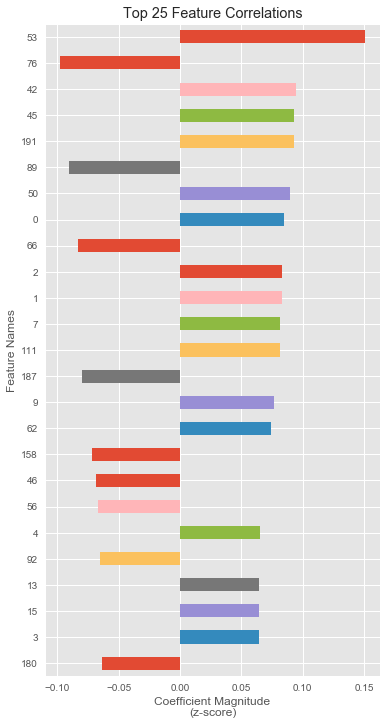

In [16]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt

%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(25) # obtains the 75 most highly-weighted attributes
wt_plt_df = pd.DataFrame(wt_plt_df)
wt_plt_df.sort_values(by='absolute_weights', inplace=True, ascending=True) # reverses the sorting

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='barh', figsize=(6,12))

ax.set_title("Top 25 Feature Correlations")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

plt.show()

### Interpreting the 10 Most Important Features

Below are interpretations for the 10 features with the largest absolute weights. There are several **important disclaimers** when interpreting the model weights and drawing conclusions about educational outcomes based on these analyses. First and foremost, the study is purely observational, which means **NO CAUSAL INFERENCE** can be made for any variables. There are without a doubt many confounding factors between the variables in our dataset and educational outcomes. The most glaringly obvious issue here is the lack of income data, something that is well-known to be a confounding factor between race and outcomes. With that in mind, any factors that appear below that are related to race, are purely associative, and likely are being confounded by racial disparities in income.

#### *ap_pct_3_or_above*
The most significant positively-correlated feature is *ap_pct_3_or_above*, which represents the percentage of students scoring a 3 or better on the AP Exam. As high scores on advanced placement exams are indicative of academic ability, we can see that this is positively associated with higher scores on the SAT. As a school's percentage of students scoring a 3 or better on the advanced placement exam increases, so does a school's average SAT score.

#### *lea_short_susp_per_c_num*
The second most informative feature, *lea_short_susp_per_c_num*, represents the number of short-term suspensions per 100 students at the district level. This is negatively correlated, indicating that a school's SAT score is expected to decrease as the number of short-term suspensions increases comparison to the district. A higher volume of suspension-level disciplinary actions both takes students out of the classroom and may coincide with an overall decrease in academic performance. Therefore, the evidence suggests a school's SAT score level will be lower as suspension volume is higher at the district level.  

#### *lea_ap_pct_3_or_above*
The third most informative feature, *lea_ap_pct_3_or_above*, similarly represents the aforementioned AP score at the district level. When comparing a particular school's AP Exam performance in relation to the other school's of the given district, this feature shows that the academic performance associated with higher advanced placement exam scores does lend itself towards increased SAT scores as well.

#### *MW_White_ENROLL_sch_pct*
This fourth most informative feature, *MW_White_ENROLL_sch_pct*, represents the school's percentage of white students enrolled. The postive correlation indicates that an increase in percentage of white enrolled students is positively associated with an increase in SAT score level. As previously mentioned, this is likely being confounded by income distribution, no meaningful conclusions can be drawn here.

#### *SBE District_Northwest*
*SBE District_Northwest*, the fifth most informative feature, is the school's presence in the State Board of Education's Northwest district. This positive correlation suggests that schools which are in the Northwest SBE district are more likely to have a higher SAT score level than schools in other districts. Further evidence to support this lies in the acknowledgment that no other SBE district indicator is contained within these top-25 features. We could conclude that schools in this district typically produce high SAT scores, and indeed higher scores than schools in other districts in North Carolina.

#### *MinorityFemalePct*
*MinorityFemalePct*, the sixth most informative feature, is the school's percentage of minority female enrolled students. This feature is negatively correlated with SAT score level, which suggests that the likelihood of a school achieving a high SAT score level decreases when the percentage of minority female students increases. As previously mentioned, this is likely being confounded by income distribution, no meaningful conclusions can be drawn here.

#### *ACTSubtests_BenchmarksMet_Asian* 
The seventh most informative feature, *ACTSubtests_BenchmarksMet_Asian*, is the percent of asian students meeting the ACT subtest benchmark. The positive correlation indicates that a school is more likely to have a high SAT score level as the percentage of asian students meeting the ACT subtest benchmark increases. There are two implications here. First, as above, we can expect that meeting benchmarks on one standardized test lends itselfs towards higher scores on another standardized test. As far as any interpretation regarding the racial demographic of this attribute, as previously mentioned, this is likely being confounded by income distribution, no meaningful conclusions can be drawn here.

#### *ACTMath_ACTBenchmark_All *
*ACTMath_ACTBenchmark_All*, the eighth most informative feature, is the percent of all students meeting the ACT math benchmark. As the SAT includes a Math component, it follows that meeting the ACT Math benchmark is positively associated with increased SAT scores. Although the two tests should not be expected to identically assess mathematical aptitude, the evidence suggests that success on the ACT Math portion lends itself towards a higher SAT score level in general.

#### *BlackFemalePct*
The ninth most informative feature, *BlackFemalePct*, is the percent of Black or African American females in the school's population. This negative correlation indicates that increasing the school's percentage of Black or African American females decreases the likelihood that a school's SAT score level will be high. As previously mentioned, this is likely being confounded by income distribution, no meaningful conclusions can be drawn here.

#### *ACTMath_ACTBenchmark_Female *
*ACTMath_ACTBenchmark_Female*, the tenth most informative feature, is the percent of female students meeting the ACT math benchmark. As the SAT includes a Math component, it follows that meeting the ACT Math benchmark is positively associated with increased SAT scores. Although the two tests should not be expected to identically assess mathematical aptitude, the evidence suggests that success on the ACT Math portion lends itself towards a higher SAT score level in general. As pertains to the specificity of this demographic subset, the implication is that a higher percentage of female students meeting the ACT Match benchmark will be associated with an increase in SAT level.


# Section 4: Interpret Feature Importance

**	10	Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset**

Below we can see that our analysis found 209 support vectors, 105 for outperforming shools, and 104 for non-outperforming.

In [37]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print('There are ' + str(svm_clf.support_.shape[0]) + ' support vectors')
print('There are ' + str(svm_clf.n_support_[0]) + ' SVs for target class 0 (not outperforming) and ' + str(svm_clf.n_support_[1]) + ' SVs for target class 1 (outperforming)')

(209, 255)
There are 209 support vectors
There are 104 SVs for target class 0 (not outperforming) and 105 SVs for target class 1 (outperforming)


In [38]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# make a dataframe of the training data
df_tested_on = hs_2017.loc[train_indices] # saved from above, the indices chosen for training
# get the support vectors from the trained model
df_support = df_tested_on.loc[svm_clf.support_,:]

df_support['sat_high_level'] = Y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
hs_2017['sat_high_level'] = Y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209 entries, 4 to 334
Columns: 256 entries, ACTMath_ACTBenchmark_All to sat_high_level
dtypes: float64(256)
memory usage: 419.6 KB


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, yo

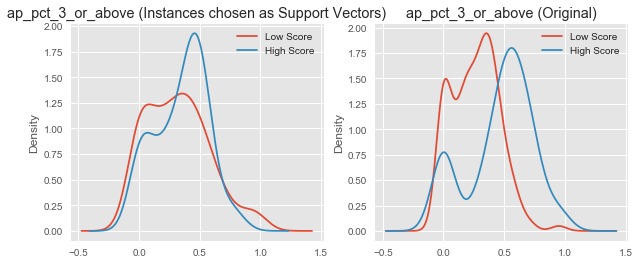

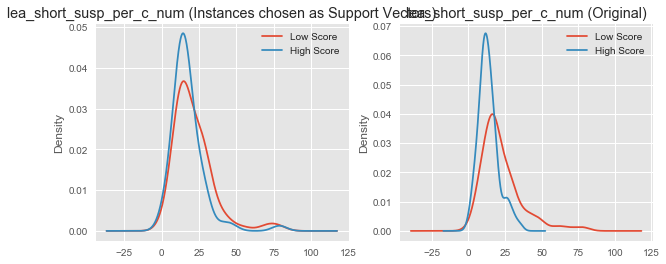

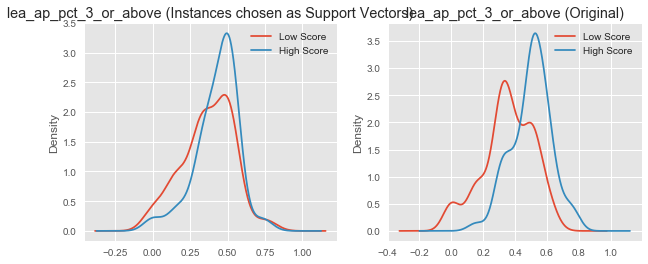

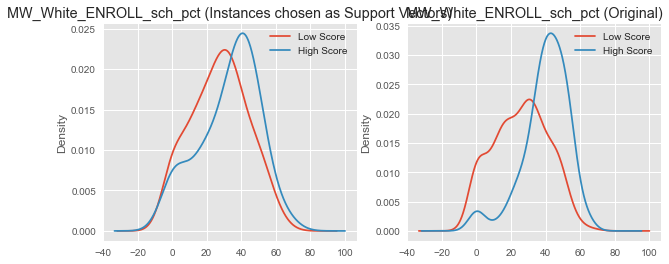

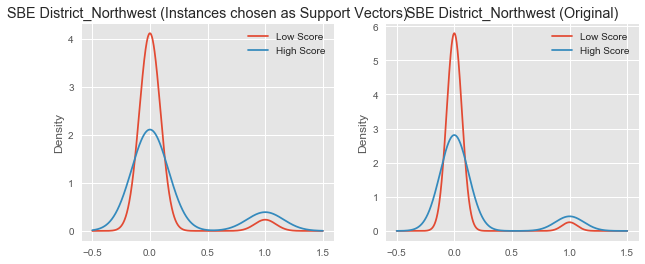

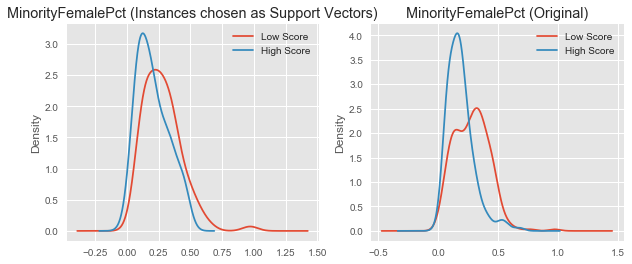

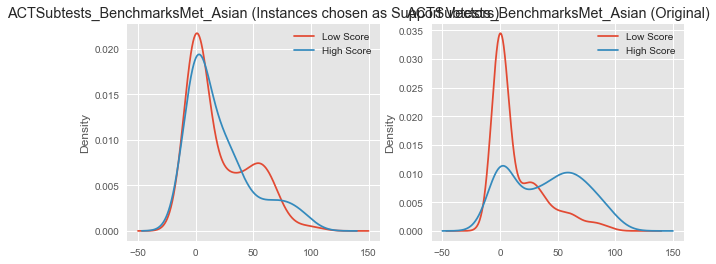

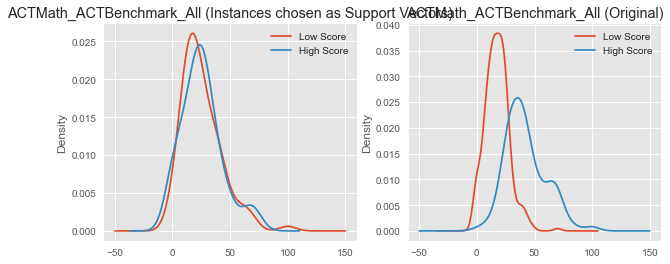

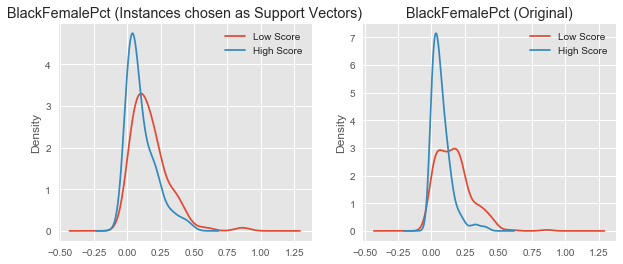

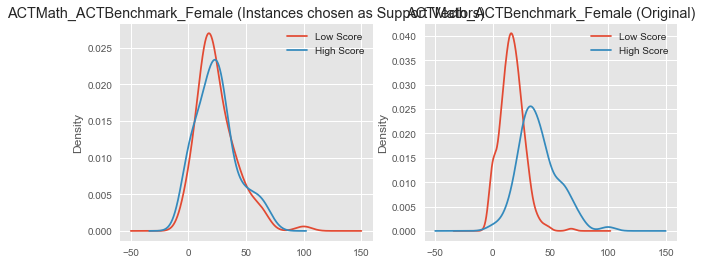

In [40]:
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['sat_high_level'])
df_grouped = hs_2017.groupby(['sat_high_level'])

# plot KDE of Different variables
vars_to_plot = ['ap_pct_3_or_above', 'lea_short_susp_per_c_num', 'lea_ap_pct_3_or_above', 'MW_White_ENROLL_sch_pct', 'SBE District_Northwest', 'MinorityFemalePct', 'ACTSubtests_BenchmarksMet_Asian', 'ACTMath_ACTBenchmark_All', 'BlackFemalePct', 'ACTMath_ACTBenchmark_Female']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Low Score','High Score'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Low Score','High Score'])
    plt.title(v+' (Original)')

## Interpretation of Top 10 Support Vectors

Just like the logistic regression above the study is purely observational, which means NO CAUSAL INFERENCE can be made for any variables. There are without a doubt many confounding factors between the variables in our dataset and educational outcomes. Similarly, the lack of data pertaining to the local communities means that many confounding variables cannot be accounted or controlled for in this study.

The graphs show the kernel density estimate of the original data, which appears on the right, versus the support vectors which appear on the left.  The variables used were chosen due to their weights in predictions.  In this case we selected the top 10 predictors.  Further discussion of these weights can be found in Section 3: Interpret Feature Importance.


### ap_pct_3_or_above
The percent of students scoring a 3 or better on the AP placement exam at the school level shows a very clear distinction between high and low SAT scores in both the original data and in the instances chosen as support vectors.  The higher the percentage of successful AP students, the more likely a high SAT score will be predicted.  This is a positive correlation and the distributions who a very pronounced advantage for high scoring schools as either the distribution skews towards higher percentages or the density is much higher.

### lea_short_susp_per_c_num
This variable addresses the number of short term suspensions per 100 students at the district level.  As expected, this is a negative correlation with the fewer short term suspensions indicating a school district is more probable to score higher on the SAT.

### lea_ap_pct_3_or_above
Similarly to the first support vector, the percentage of students scoring a 3 or better on the AP placement exam at the district level shows a very clear distinction between high and low SAT scores in both the original data and in the instances chosen as support vectors.  This means that schools in districts with successful AP programs are much more likley to assist in predicting higher SAT scores.

### MW_White_ENROLL_sch_pct
The overall percentage of the school population comprised of white caucasians, either male or female.  This shows a positive correlation as a school is more likely to show a higher SAT score with a higher white population.  Low scoring schools are more broadly distributed and the original data shows a much more pronounced separation with the support vectors smoothing things out.  We caution against drawing conclusions about this data outside of the very narrow window thi study covers.  The data is limited to only school-centric data and thus the study cannot control for a number of confounding variables.

### SBE District_Northwest
A binary variable marking the presence of a school in the SBE District Northwest section of North Carolina shows some interesting data points.  Clearly this variable shows that schools within this district are more likley to perform well on the SAT compared to schools outside the mentioned district.  The bimodal distribution stems from the binary nature of the variable itself, so the only possible values are 0 or 1.  The KDE plot makes it very easy to see the success rates in both the original data and support vector.

### MinorityFemalePct
The kernel density plot for the overall percentage of minority females enrolled at the school shows a negative correlation between high SAT scores and the variable.  The original data is more broadly distributed with less overlap while the support vectors are more closely overlaped.  We caution against drawing conclusions from this though since we cannot control for a societal factors that may confound the underlying reason for the negative correlation.

### ACTSubtests_BenchMarksMet_Asian
The percentage of asians meeting the ACT subtests benchmark score (18) is a strong indicator of higher SAT scores.  The oriignal data is bimodal in distribution while the support vector shows much clearer trends.  The bimodal nature can likely be explained by the absence or low population of asian students at many schools.  The small population makes it easily swayed by influential data points and the absence of data.

### ACTMath_ACTBenchmark_All
This variable looks at percetage of students (all races and genders) who achieved the benchmark score (18) on the math subtest of the ACT.  We can see a clear positive correlation between high scores and ACT Math benchmarks on both the support vector and the original data.  The support vector however shows a greater degree of overlap.

### BlackFemalePct
This variable represents the percentage of black female students enrolled at the school.  This distributions and density of the original are more disparate than the SVM, although both reflect a negative correlation where we expect the SAT scores to be lower as the population of black females increases.  Again, we caution against drawing too many conclusions from this since we cannot control for a number of societal factors that are likely confounding the real reason for this negative correlation.

### ACTMath_ACTBenchmark_Female
This variables represents the percent of females at the school that met the benchmark (18) on the ACT for the math subtest.  The original data shows a much clearer distinction between low scoring schools and high scoring schools of this positively correlated variable.  That is, the higher the ACT Math scoresfor females, we estimate the more likely a school is to score high on the SAT.

In [20]:
# Placeholder for code or markdown related to section 4

In [21]:
# Placeholder for code or markdown related to section 4

# References

[1]https://web.stanford.edu/~hastie/Papers/svmtalk.pdf